In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
# Load datasets
train1_path = r'C:\Geo\MISSA KESWAL-01.CSV'
train3_path = r'C:\Geo\MISSA KESWAL-03.CSV'
qazian_path = r'C:\Geo\QAZIAN -1X.CSV'
blind_well_path = r'C:\Geo\MISSA KESWAL-02.CSV'

train1 = pd.read_csv(train1_path)
train3 = pd.read_csv(train3_path)
qazian = pd.read_csv(qazian_path)
blind_well = pd.read_csv(blind_well_path)

In [3]:
# Replace -999.25 with NaN
for df in [train1, train3, qazian, blind_well]:
    df.replace(-999.25, np.nan, inplace=True)


def early_imputation(df, well_name):
    """Impute NaN values immediately after replacement"""
    print(f"\nPerforming early imputation for {well_name}...")
    
    nan_counts_before = df.isnull().sum()
    total_nans_before = nan_counts_before.sum()
    
    if total_nans_before > 0:
        print(f"  Total NaN values before imputation: {total_nans_before}")
        
        # Sort by depth if available for better continuity
        if 'DEPTH' in df.columns:
            df = df.sort_values('DEPTH').reset_index(drop=True)
        
        # Apply forward fill 
        df.fillna(method='ffill', inplace=True)
        
        # Apply backward fill for any remaining NaN at the beginning
        df.fillna(method='bfill', inplace=True)
        
        # Check if any NaN values remain 
        nan_counts_after = df.isnull().sum()
        total_nans_after = nan_counts_after.sum()
        
        if total_nans_after > 0:
            print(f"  Warning: {total_nans_after} NaN values remain after forward/backward fill")
            # For any remaining NaN, use column-wise interpolation or median
            for col in df.columns:
                if df[col].isnull().any():
                    # Try interpolation first
                    df[col] = df[col].interpolate(method='linear')
                    
                    if df[col].isnull().any():
                        median_val = df[col].median()
                        if pd.notna(median_val):
                            df[col].fillna(median_val, inplace=True)
                        else:

                            df[col].fillna(0, inplace=True)
                            print(f"    Column '{col}' had no valid values, filled with 0")
        
        print(f"  Imputation complete. NaN values reduced from {total_nans_before} to {df.isnull().sum().sum()}")
    else:
        print(f"  No NaN values found in {well_name}")
    
    return df

# Apply early imputation to all datasets
train1 = early_imputation(train1, 'MISSA KESWAL-01')
train3 = early_imputation(train3, 'MISSA KESWAL-03')
qazian = early_imputation(qazian, 'QAZIAN-1X')
blind_well = early_imputation(blind_well, 'MISSA KESWAL-02')


def clean_and_filter_data(df, well_name):
    """Clean data and filter out unrealistic values"""
    print(f"\nCleaning {well_name}...")
    
    # Select relevant columns
    required_cols = ['PPP', 'DEPTH', 'GR', 'DT', 'VCL', 'DT_NCT', 'RHOB_combined', 
                     'RES_DEEP', 'SPHI', 'HP', 'OB']
    available_cols = [col for col in required_cols if col in df.columns]
    df_clean = df[available_cols].copy()
    
    initial_rows = len(df_clean)
    
    # Remove rows with unrealistic pressure gradients
    if 'PPP' in df_clean.columns and 'DEPTH' in df_clean.columns:
        depth_ft = df_clean['DEPTH'] * 3.28084
        gradient = df_clean['PPP'] / depth_ft
        
        # Keep only realistic gradients (0.3 to 1.2 psi/ft)
        valid_gradient = (gradient >= 0.3) & (gradient <= 1.2)
        df_clean = df_clean[valid_gradient]
        
        removed_gradient = initial_rows - len(df_clean)
        if removed_gradient > 0:
            print(f"  Removed {removed_gradient} rows with unrealistic pressure gradients")
    
    # Remove extreme outliers in RHOB_combined
    if 'RHOB_combined' in df_clean.columns:
        # Typical bulk density range: 1.8 to 2.8 g/cc
        valid_rhob = (df_clean['RHOB_combined'] >= 1.8) & (df_clean['RHOB_combined'] <= 2.8)
        df_clean = df_clean[valid_rhob | df_clean['RHOB_combined'].isna()]
    
    # Add well identifier
    df_clean['WELL'] = well_name
    
    print(f"  Final rows: {len(df_clean)} (removed {initial_rows - len(df_clean)} total)")
    
    return df_clean

# Clean all datasets
train1_clean = clean_and_filter_data(train1, 'MISSA KESWAL-01')
train3_clean = clean_and_filter_data(train3, 'MISSA KESWAL-03')
qazian_clean = clean_and_filter_data(qazian, 'QAZIAN-1X')
blind_well_clean = clean_and_filter_data(blind_well, 'MISSA KESWAL-02')



def robust_imputation(df, well_name):
    """Additional imputation using robust methods if any NaN values remain"""
    print(f"\nChecking for additional imputation needs in {well_name}...")
    
    df_imputed = df.copy()
    
    # Check if any NaN values remain after early imputation
    total_nans = df_imputed.isnull().sum().sum()
    if total_nans == 0:
        print(f"  No additional imputation needed - all values already filled")
        return df_imputed
    
    print(f"  Found {total_nans} NaN values requiring additional imputation")
    
    # Sort by depth for better interpolation
    if 'DEPTH' in df_imputed.columns:
        df_imputed = df_imputed.sort_values('DEPTH')
    
   
    for col in df_imputed.columns:
        if col in ['WELL', 'DEPTH']:
            continue
            
        missing_count = df_imputed[col].isnull().sum()
        if missing_count > 0:
            # For continuous features, use interpolation
            if col in ['PPP', 'DT', 'RHOB_combined', 'GR', 'RES_DEEP']:
                # Linear interpolation with limit
                df_imputed[col] = df_imputed[col].interpolate(method='linear', limit=10)
                
                # Forward/backward fill for edges
                df_imputed[col] = df_imputed[col].fillna(method='ffill', limit=5)
                df_imputed[col] = df_imputed[col].fillna(method='bfill', limit=5)
            
            # Fill remaining with median
            if df_imputed[col].isnull().sum() > 0:
                median_val = df_imputed[col].median()
                df_imputed[col].fillna(median_val, inplace=True)
    
    return df_imputed

train1_imputed = robust_imputation(train1_clean, 'MISSA KESWAL-01')
train3_imputed = robust_imputation(train3_clean, 'MISSA KESWAL-03')
qazian_imputed = robust_imputation(qazian_clean, 'QAZIAN-1X')
blind_well_imputed = robust_imputation(blind_well_clean, 'MISSA KESWAL-02')


Performing early imputation for MISSA KESWAL-01...
  Total NaN values before imputation: 28680
  Imputation complete. NaN values reduced from 28680 to 0

Performing early imputation for MISSA KESWAL-03...
  Total NaN values before imputation: 36345
  Imputation complete. NaN values reduced from 36345 to 0

Performing early imputation for QAZIAN-1X...
  Total NaN values before imputation: 47593
  Imputation complete. NaN values reduced from 47593 to 0

Performing early imputation for MISSA KESWAL-02...
  Total NaN values before imputation: 10662
  Imputation complete. NaN values reduced from 10662 to 0

Cleaning MISSA KESWAL-01...
  Final rows: 6974 (removed 45 total)

Cleaning MISSA KESWAL-03...
  Removed 142 rows with unrealistic pressure gradients
  Final rows: 6854 (removed 688 total)

Cleaning QAZIAN-1X...
  Removed 1548 rows with unrealistic pressure gradients
  Final rows: 7391 (removed 1691 total)

Cleaning MISSA KESWAL-02...
  Removed 775 rows with unrealistic pressure gradien

In [4]:
# Find depth overlap between training and blind well
blind_depth_min = blind_well_imputed['DEPTH'].min()
blind_depth_max = blind_well_imputed['DEPTH'].max()

print(f"\nBlind well depth range: {blind_depth_min:.1f} - {blind_depth_max:.1f} m")

# Filter training data to similar depth range (with 10% buffer)
depth_buffer = 0.1 * (blind_depth_max - blind_depth_min)
depth_min_filter = blind_depth_min - depth_buffer
depth_max_filter = blind_depth_max + depth_buffer

def filter_by_depth(df, min_depth, max_depth):
    return df[(df['DEPTH'] >= min_depth) & (df['DEPTH'] <= max_depth)]

train1_matched = filter_by_depth(train1_imputed, depth_min_filter, depth_max_filter)
train3_matched = filter_by_depth(train3_imputed, depth_min_filter, depth_max_filter)
qazian_matched = filter_by_depth(qazian_imputed, depth_min_filter, depth_max_filter)

print(f"Depth-matched training samples:")
print(f"  MISSA KESWAL-01: {len(train1_matched)}")
print(f"  MISSA KESWAL-03: {len(train3_matched)}")
print(f"  QAZIAN-1X: {len(qazian_matched)}")



def create_robust_features(df):
    """Create features with numerical stability and bounds checking"""
    df_feat = df.copy()
    
    # Basic features 
    if 'DEPTH' in df_feat.columns:
        # Normalized depth (0-1 scale within each well)
        df_feat['DEPTH_norm'] = (df_feat['DEPTH'] - df_feat['DEPTH'].min()) / (df_feat['DEPTH'].max() - df_feat['DEPTH'].min())
        
        # Depth squared (scaled)
        df_feat['DEPTH_sq_scaled'] = (df_feat['DEPTH'] / 1000) ** 2
    
    # Hydrostatic pressure (normal gradient)
    if 'DEPTH' in df_feat.columns:
        df_feat['Hydrostatic'] = 0.433 * df_feat['DEPTH'] * 3.28084  # Convert to ft
    
    # Overburden gradient (with bounds)
    if 'OB' in df_feat.columns and 'DEPTH' in df_feat.columns:
        depth_ft = df_feat['DEPTH'] * 3.28084
        df_feat['OB_gradient'] = df_feat['OB'] / (depth_ft + 1)  # Add 1 to avoid division by zero
        # Clip to reasonable range
        df_feat['OB_gradient'] = np.clip(df_feat['OB_gradient'], 0.5, 1.5)
    
    # Velocity ratio (with bounds)
    if 'DT' in df_feat.columns and 'DT_NCT' in df_feat.columns:
        # Ensure no zeros or negative values
        dt_safe = np.maximum(df_feat['DT'], 40)  # Minimum realistic DT
        dt_nct_safe = np.maximum(df_feat['DT_NCT'], 40)
        
        df_feat['Velocity_ratio'] = dt_nct_safe / dt_safe
        # Clip to reasonable range
        df_feat['Velocity_ratio'] = np.clip(df_feat['Velocity_ratio'], 0.5, 2.0)
    
    # Porosity estimate from density (with bounds)
    if 'RHOB_combined' in df_feat.columns:
        # Ensure density is in valid range
        rhob_safe = np.clip(df_feat['RHOB_combined'], 1.8, 2.8)
        df_feat['Porosity_density'] = (2.65 - rhob_safe) / (2.65 - 1.0)
        df_feat['Porosity_density'] = np.clip(df_feat['Porosity_density'], 0, 0.4)
    
    # Shale volume indicator
    if 'VCL' in df_feat.columns:
        df_feat['VCL_bounded'] = np.clip(df_feat['VCL'], 0, 1)
    
    # Composite features (bounded)
    if 'GR' in df_feat.columns:
        # Normalize GR to 0-1 scale
        gr_min, gr_max = df_feat['GR'].quantile([0.01, 0.99])
        df_feat['GR_norm'] = (df_feat['GR'] - gr_min) / (gr_max - gr_min + 1)
        df_feat['GR_norm'] = np.clip(df_feat['GR_norm'], 0, 1)
    
    # Moving averages for smoothing
    window = 21  # ~10m window assuming 0.5m sampling
    for col in ['DT', 'RHOB_combined', 'GR']:
        if col in df_feat.columns:
            df_feat[f'{col}_ma'] = df_feat[col].rolling(window=window, center=True, min_periods=1).mean()
    
    # Interaction features (all bounded)
    if 'DT' in df_feat.columns and 'RHOB_combined' in df_feat.columns:
        # Acoustic impedance (normalized)
        dt_safe = np.maximum(df_feat['DT'], 40)
        rhob_safe = np.clip(df_feat['RHOB_combined'], 1.8, 2.8)
        df_feat['AI_norm'] = rhob_safe / (dt_safe / 100)  # Scale DT
    
    return df_feat

# Apply feature engineering
train1_features = create_robust_features(train1_matched)
train3_features = create_robust_features(train3_matched)
qazian_features = create_robust_features(qazian_matched)
blind_features = create_robust_features(blind_well_imputed)

# Combine training data
train_combined = pd.concat([train1_features, train3_features, qazian_features], 
                          ignore_index=True)

print(f"\nCombined training samples: {len(train_combined)}")
print(f"Blind well samples: {len(blind_features)}")



# Select features (exclude identifiers and target)
feature_columns = [col for col in train_combined.columns 
                  if col not in ['PPP', 'WELL', 'DEPTH']]  

# Remove any features with NaN or inf
for col in feature_columns.copy():
    if train_combined[col].isnull().any() or np.isinf(train_combined[col]).any():
        feature_columns.remove(col)
        print(f"Removed feature {col} due to NaN or inf values")

print(f"\nFinal features ({len(feature_columns)}): {feature_columns}")

# Prepare data
X_train_full = train_combined[feature_columns].values
y_train_full = train_combined['PPP'].values

X_blind = blind_features[feature_columns].values
y_blind = blind_features['PPP'].values

# Final check for finite values
assert np.all(np.isfinite(X_train_full)), "Training features contain non-finite values"
assert np.all(np.isfinite(X_blind)), "Blind well features contain non-finite values"


Blind well depth range: 1100.0 - 1803.2 m
Depth-matched training samples:
  MISSA KESWAL-01: 5046
  MISSA KESWAL-03: 4487
  QAZIAN-1X: 4034

Combined training samples: 13567
Blind well samples: 4644

Final features (21): ['GR', 'DT', 'VCL', 'DT_NCT', 'RHOB_combined', 'RES_DEEP', 'SPHI', 'HP', 'OB', 'DEPTH_norm', 'DEPTH_sq_scaled', 'Hydrostatic', 'OB_gradient', 'Velocity_ratio', 'Porosity_density', 'VCL_bounded', 'GR_norm', 'DT_ma', 'RHOB_combined_ma', 'GR_ma', 'AI_norm']



TRAINING MODELS WITH ROBUST FEATURES

Model 1: Random Forest (Baseline)
Validation - RMSE: 41.57 psi, R²: 0.9970
Blind Well - RMSE: 526.27 psi, R²: 0.0892

Model 2: XGBoost with Strong Regularization
Validation - RMSE: 68.50 psi, R²: 0.9918
Blind Well - RMSE: 485.84 psi, R²: 0.2237

Model 3: Conservative Ensemble
Validation - RMSE: 178.98 psi, R²: 0.9441
Blind Well - RMSE: 487.42 psi, R²: 0.2187

Applying bias correction...
Systematic bias: -25.58 psi
After bias correction - RMSE: 485.17 psi, R²: 0.2259


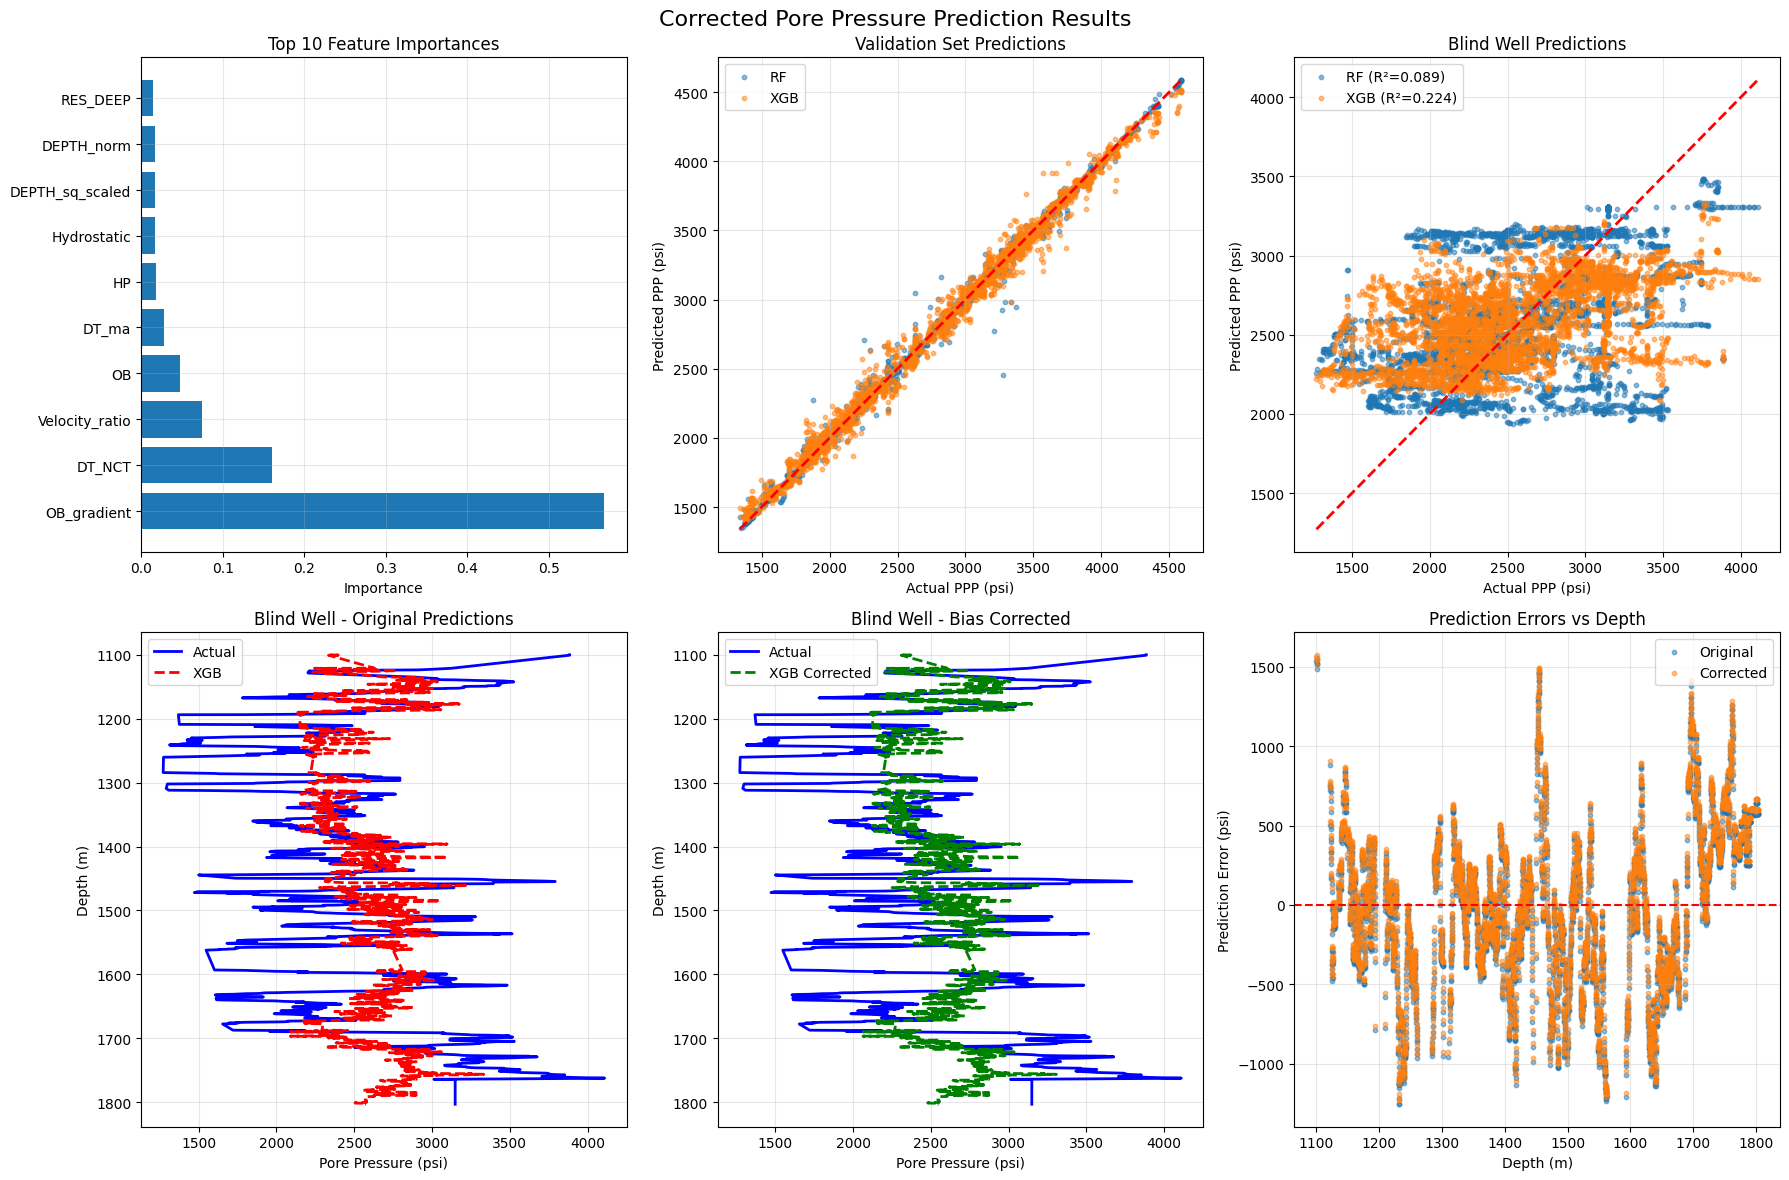


SUMMARY REPORT - CORRECTED IMPLEMENTATION

Data Statistics:
Training samples (depth-matched): 13567
Blind well samples: 4644
Features used: 21

Model Performance:

1. Random Forest (Baseline):
   Validation - RMSE: 41.57 psi, R²: 0.9970
   Blind Well - RMSE: 526.27 psi, R²: 0.0892

2. XGBoost (Regularized):
   Validation - RMSE: 68.50 psi, R²: 0.9918
   Blind Well - RMSE: 485.84 psi, R²: 0.2237

3. Conservative Ensemble:
   Validation - RMSE: 178.98 psi, R²: 0.9441
   Blind Well - RMSE: 487.42 psi, R²: 0.2187

4. XGBoost with Bias Correction:
   Blind Well - RMSE: 485.17 psi, R²: 0.2259


In [5]:
# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Use RobustScaler for outlier resistance
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_blind_scaled = scaler.transform(X_blind)

print("\n" + "="*60)
print("TRAINING MODELS WITH ROBUST FEATURES")
print("="*60)

# Model 1: Random Forest (baseline)
print("\nModel 1: Random Forest (Baseline)")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

y_pred_val_rf = rf_model.predict(X_val_scaled)
y_pred_blind_rf = rf_model.predict(X_blind_scaled)

rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
r2_val_rf = r2_score(y_val, y_pred_val_rf)
rmse_blind_rf = np.sqrt(mean_squared_error(y_blind, y_pred_blind_rf))
r2_blind_rf = r2_score(y_blind, y_pred_blind_rf)

print(f"Validation - RMSE: {rmse_val_rf:.2f} psi, R²: {r2_val_rf:.4f}")
print(f"Blind Well - RMSE: {rmse_blind_rf:.2f} psi, R²: {r2_blind_rf:.4f}")

# Model 2: XGBoost with regularization
print("\nModel 2: XGBoost with Strong Regularization")
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=10,
    gamma=0.5,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

y_pred_val_xgb = xgb_model.predict(X_val_scaled)
y_pred_blind_xgb = xgb_model.predict(X_blind_scaled)

rmse_val_xgb = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
r2_val_xgb = r2_score(y_val, y_pred_val_xgb)
rmse_blind_xgb = np.sqrt(mean_squared_error(y_blind, y_pred_blind_xgb))
r2_blind_xgb = r2_score(y_blind, y_pred_blind_xgb)

print(f"Validation - RMSE: {rmse_val_xgb:.2f} psi, R²: {r2_val_xgb:.4f}")
print(f"Blind Well - RMSE: {rmse_blind_xgb:.2f} psi, R²: {r2_blind_xgb:.4f}")

# Model 3: Conservative ensemble
print("\nModel 3: Conservative Ensemble")

# Train multiple simple models
ensemble_predictions_val = []
ensemble_predictions_blind = []

for i in range(5):
    # Use different subsets of features
    n_features = int(0.7 * len(feature_columns))
    feature_indices = np.random.choice(len(feature_columns), n_features, replace=False)
    
    # Simple model with strong regularization
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=2.0,
        reg_lambda=10.0,
        random_state=42+i
    )
    
    model.fit(X_train_scaled[:, feature_indices], y_train)
    
    pred_val = model.predict(X_val_scaled[:, feature_indices])
    pred_blind = model.predict(X_blind_scaled[:, feature_indices])
    
    ensemble_predictions_val.append(pred_val)
    ensemble_predictions_blind.append(pred_blind)

# Use median for robustness
ensemble_val = np.median(ensemble_predictions_val, axis=0)
ensemble_blind = np.median(ensemble_predictions_blind, axis=0)

rmse_val_ens = np.sqrt(mean_squared_error(y_val, ensemble_val))
r2_val_ens = r2_score(y_val, ensemble_val)
rmse_blind_ens = np.sqrt(mean_squared_error(y_blind, ensemble_blind))
r2_blind_ens = r2_score(y_blind, ensemble_blind)

print(f"Validation - RMSE: {rmse_val_ens:.2f} psi, R²: {r2_val_ens:.4f}")
print(f"Blind Well - RMSE: {rmse_blind_ens:.2f} psi, R²: {r2_blind_ens:.4f}")

# ===================== BIAS CORRECTION =====================

print("\nApplying bias correction...")

# Calculate systematic bias
bias = np.mean(y_blind) - np.mean(y_pred_blind_xgb)
print(f"Systematic bias: {bias:.2f} psi")

# Apply simple bias correction
y_pred_blind_xgb_corrected = y_pred_blind_xgb + bias
rmse_blind_xgb_corrected = np.sqrt(mean_squared_error(y_blind, y_pred_blind_xgb_corrected))
r2_blind_xgb_corrected = r2_score(y_blind, y_pred_blind_xgb_corrected)

print(f"After bias correction - RMSE: {rmse_blind_xgb_corrected:.2f} psi, R²: {r2_blind_xgb_corrected:.4f}")

# ===================== VISUALIZATION =====================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Corrected Pore Pressure Prediction Results', fontsize=16)

# 1. Feature importance
ax = axes[0, 0]
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax.barh(range(len(feature_importance)), feature_importance['importance'])
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['feature'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Feature Importances')
ax.grid(True, alpha=0.3)

# 2. Validation predictions
ax = axes[0, 1]
ax.scatter(y_val, y_pred_val_rf, alpha=0.5, s=10, label='RF')
ax.scatter(y_val, y_pred_val_xgb, alpha=0.5, s=10, label='XGB')
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title('Validation Set Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Blind well predictions
ax = axes[0, 2]
ax.scatter(y_blind, y_pred_blind_rf, alpha=0.5, s=10, label=f'RF (R²={r2_blind_rf:.3f})')
ax.scatter(y_blind, y_pred_blind_xgb, alpha=0.5, s=10, label=f'XGB (R²={r2_blind_xgb:.3f})')
ax.plot([y_blind.min(), y_blind.max()], [y_blind.min(), y_blind.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title('Blind Well Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Depth profile - Original
ax = axes[1, 0]
blind_depth = blind_features['DEPTH'].values
ax.plot(y_blind, blind_depth, 'b-', label='Actual', linewidth=2)
ax.plot(y_pred_blind_xgb, blind_depth, 'r--', label='XGB', linewidth=2)
ax.set_xlabel('Pore Pressure (psi)')
ax.set_ylabel('Depth (m)')
ax.set_title('Blind Well - Original Predictions')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

# 5. Depth profile - Bias corrected
ax = axes[1, 1]
ax.plot(y_blind, blind_depth, 'b-', label='Actual', linewidth=2)
ax.plot(y_pred_blind_xgb_corrected, blind_depth, 'g--', label='XGB Corrected', linewidth=2)
ax.set_xlabel('Pore Pressure (psi)')
ax.set_ylabel('Depth (m)')
ax.set_title('Blind Well - Bias Corrected')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

# 6. Error analysis
ax = axes[1, 2]
errors = y_blind - y_pred_blind_xgb
errors_corrected = y_blind - y_pred_blind_xgb_corrected
ax.scatter(blind_depth, errors, alpha=0.5, s=10, label='Original')
ax.scatter(blind_depth, errors_corrected, alpha=0.5, s=10, label='Corrected')
ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Prediction Error (psi)')
ax.set_title('Prediction Errors vs Depth')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('corrected_pore_pressure_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ===================== SUMMARY REPORT =====================

print("\n" + "="*80)
print("SUMMARY REPORT - CORRECTED IMPLEMENTATION")
print("="*80)

print("\nData Statistics:")
print(f"Training samples (depth-matched): {len(X_train_full)}")
print(f"Blind well samples: {len(X_blind)}")
print(f"Features used: {len(feature_columns)}")

print("\nModel Performance:")
print("\n1. Random Forest (Baseline):")
print(f"   Validation - RMSE: {rmse_val_rf:.2f} psi, R²: {r2_val_rf:.4f}")
print(f"   Blind Well - RMSE: {rmse_blind_rf:.2f} psi, R²: {r2_blind_rf:.4f}")

print("\n2. XGBoost (Regularized):")
print(f"   Validation - RMSE: {rmse_val_xgb:.2f} psi, R²: {r2_val_xgb:.4f}")
print(f"   Blind Well - RMSE: {rmse_blind_xgb:.2f} psi, R²: {r2_blind_xgb:.4f}")

print("\n3. Conservative Ensemble:")
print(f"   Validation - RMSE: {rmse_val_ens:.2f} psi, R²: {r2_val_ens:.4f}")
print(f"   Blind Well - RMSE: {rmse_blind_ens:.2f} psi, R²: {r2_blind_ens:.4f}")

print("\n4. XGBoost with Bias Correction:")
print(f"   Blind Well - RMSE: {rmse_blind_xgb_corrected:.2f} psi, R²: {r2_blind_xgb_corrected:.4f}")

## With Blind well data augmentation

Loading and preprocessing data...

Performing early imputation for MISSA KESWAL-01...
  Total NaN values before imputation: 28680
  Imputation complete. NaN values reduced from 28680 to 0

Performing early imputation for MISSA KESWAL-03...
  Total NaN values before imputation: 36345
  Imputation complete. NaN values reduced from 36345 to 0

Performing early imputation for QAZIAN-1X...
  Total NaN values before imputation: 47593
  Imputation complete. NaN values reduced from 47593 to 0

Performing early imputation for MISSA KESWAL-02...
  Total NaN values before imputation: 10662
  Imputation complete. NaN values reduced from 10662 to 0

Cleaning MISSA KESWAL-01...
  Final rows: 6974 (removed 45 total)

Cleaning MISSA KESWAL-03...
  Removed 142 rows with unrealistic pressure gradients
  Final rows: 6854 (removed 688 total)

Cleaning QAZIAN-1X...
  Removed 1548 rows with unrealistic pressure gradients
  Final rows: 7391 (removed 1691 total)

Cleaning MISSA KESWAL-02...
  Removed 775 rows

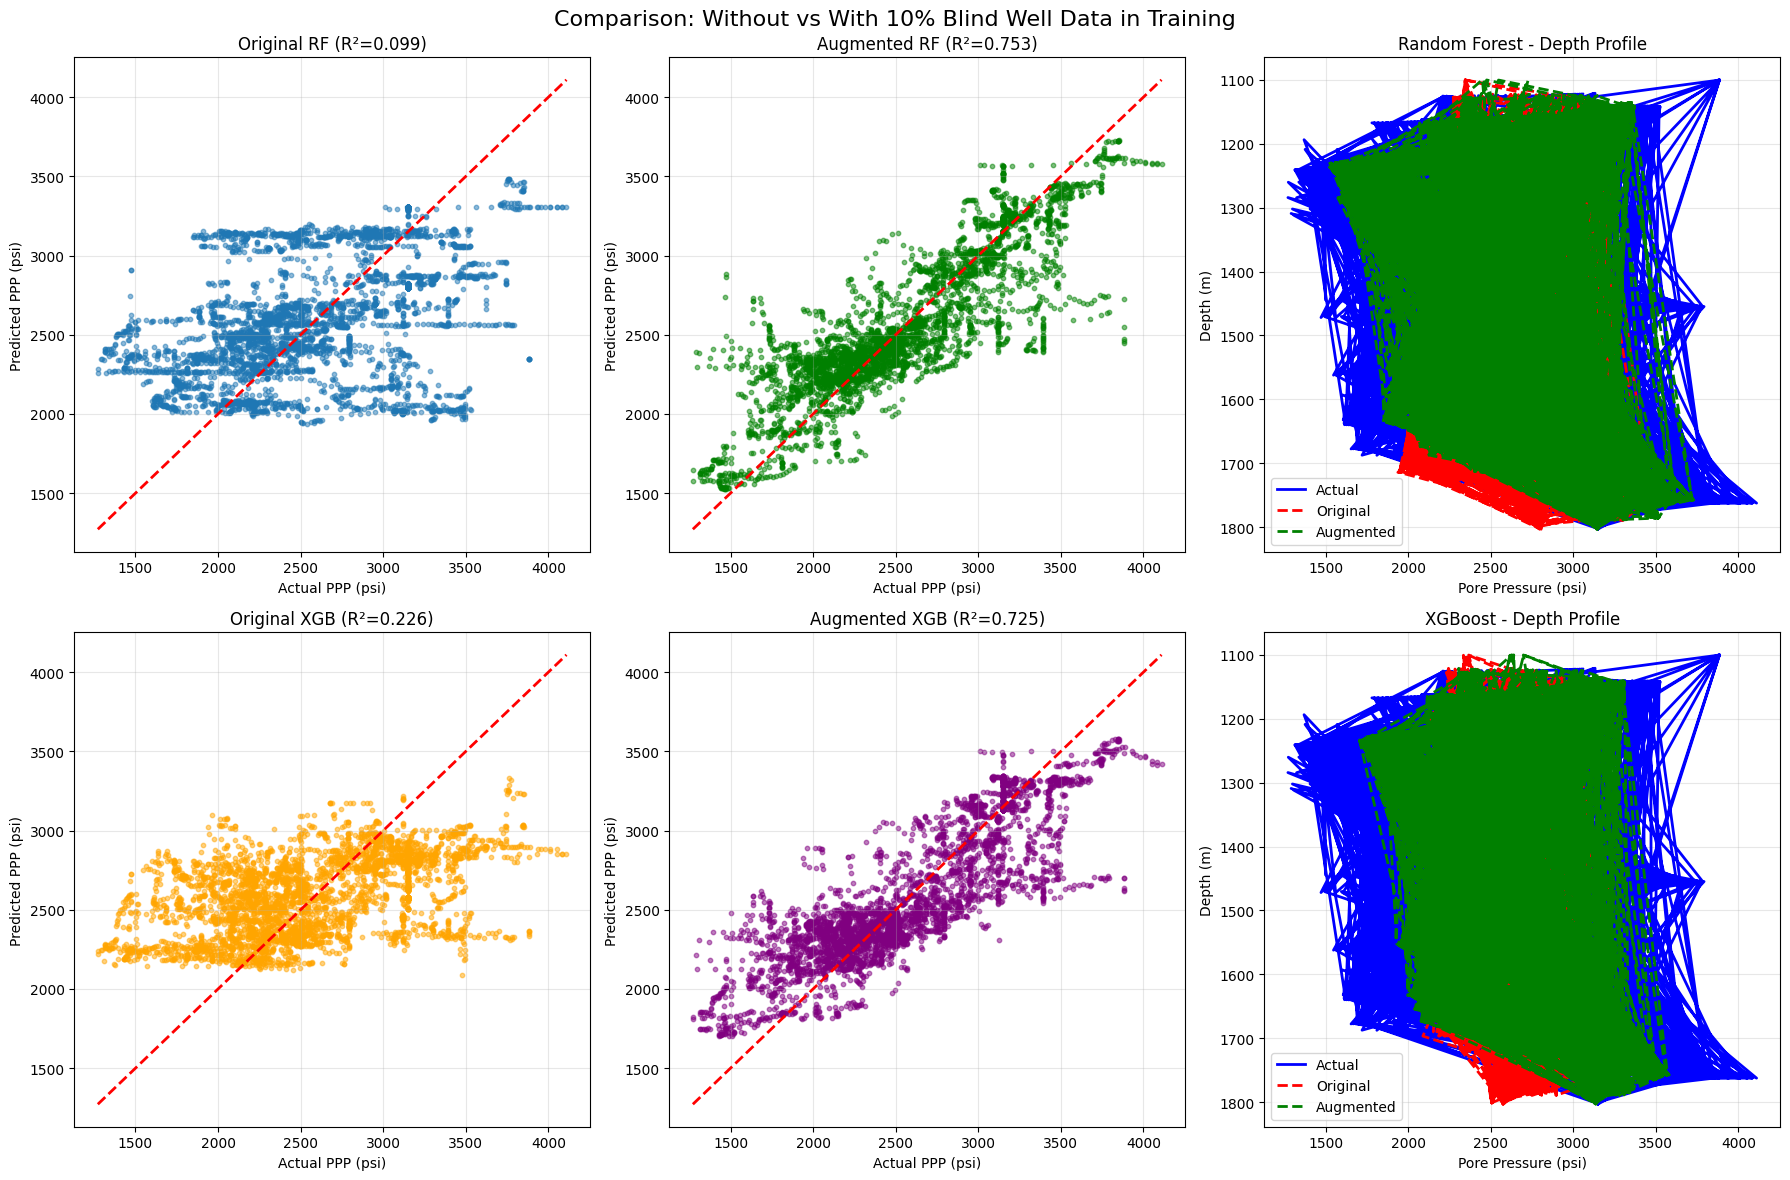

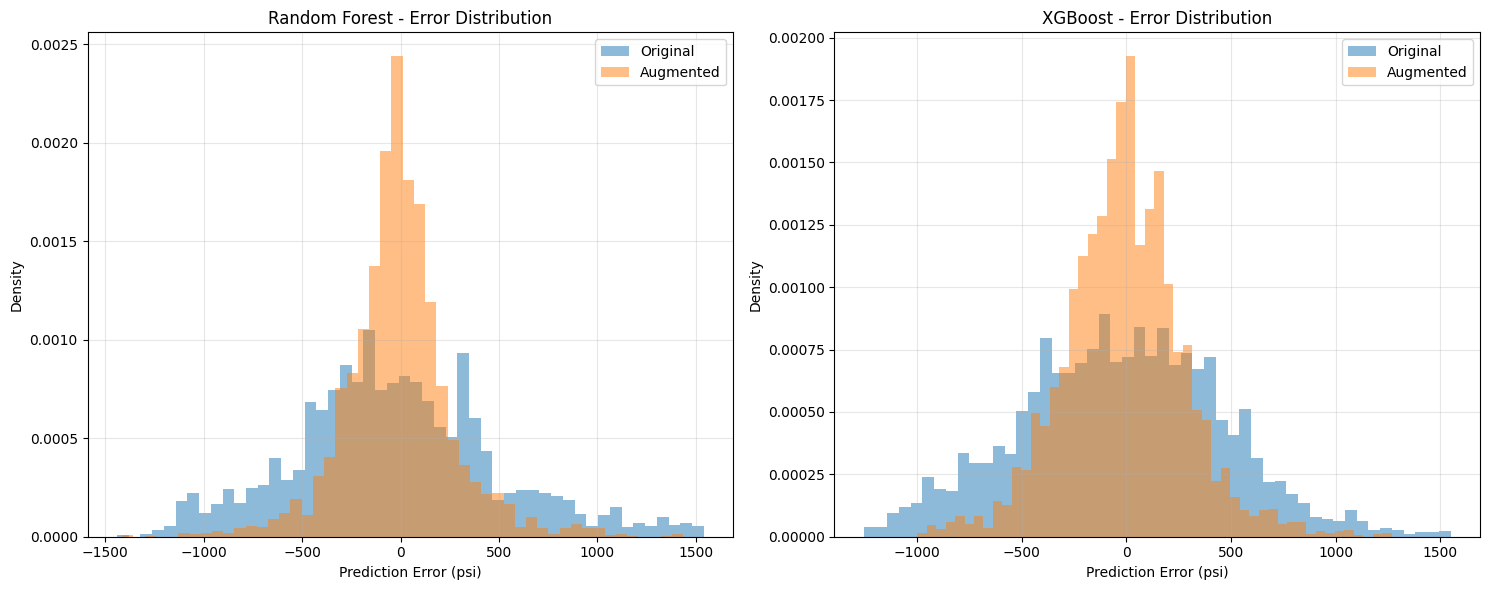


FINAL SUMMARY REPORT - BLIND WELL DATA AUGMENTATION EXPERIMENT

Experiment Setup:
- Total blind well samples: 4644
- Training samples from blind well (10%): 464
- Test samples from blind well (90%): 4180
- Original training samples: 13567
- Augmented training samples: 14031

Performance Comparison (on 90% blind well test set):

1. Random Forest:
   Without blind data - RMSE: 523.55 psi, R²: 0.0990
   With 10% blind data - RMSE: 274.37 psi, R²: 0.7526
   Improvement: 47.6% RMSE reduction

2. XGBoost:
   Without blind data - RMSE: 485.15 psi, R²: 0.2263
   With 10% blind data - RMSE: 289.08 psi, R²: 0.7253
   Improvement: 40.4% RMSE reduction


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# ===================== DATA LOADING =====================

print("Loading and preprocessing data...")

# Load datasets
train1_path = r'C:\Geo\MISSA KESWAL-01.CSV'
train3_path = r'C:\Geo\MISSA KESWAL-03.CSV'
qazian_path = r'C:\Geo\QAZIAN -1X.CSV'
blind_well_path = r'C:\Geo\MISSA KESWAL-02.CSV'

train1 = pd.read_csv(train1_path)
train3 = pd.read_csv(train3_path)
qazian = pd.read_csv(qazian_path)
blind_well = pd.read_csv(blind_well_path)

# Replace -999.25 with NaN
for df in [train1, train3, qazian, blind_well]:
    df.replace(-999.25, np.nan, inplace=True)

# ===================== EARLY NaN IMPUTATION =====================

def early_imputation(df, well_name):
    """Impute NaN values immediately after replacement"""
    print(f"\nPerforming early imputation for {well_name}...")
    
    # Count NaN values before imputation
    nan_counts_before = df.isnull().sum()
    total_nans_before = nan_counts_before.sum()
    
    if total_nans_before > 0:
        print(f"  Total NaN values before imputation: {total_nans_before}")
        
        # Sort by depth if available for better continuity
        if 'DEPTH' in df.columns:
            df = df.sort_values('DEPTH').reset_index(drop=True)
        
        # Apply forward fill (use previous value)
        df.fillna(method='ffill', inplace=True)
        
        # Apply backward fill for any remaining NaN at the beginning
        df.fillna(method='bfill', inplace=True)
        
        # Check if any NaN values remain (in case entire columns were NaN)
        nan_counts_after = df.isnull().sum()
        total_nans_after = nan_counts_after.sum()
        
        if total_nans_after > 0:
            print(f"  Warning: {total_nans_after} NaN values remain after forward/backward fill")
            # For any remaining NaN, use column-wise interpolation or median
            for col in df.columns:
                if df[col].isnull().any():
                    # Try interpolation first
                    df[col] = df[col].interpolate(method='linear')
                    # If still NaN (e.g., entire column was NaN), use median of non-NaN values
                    if df[col].isnull().any():
                        median_val = df[col].median()
                        if pd.notna(median_val):
                            df[col].fillna(median_val, inplace=True)
                        else:
                            # If no valid values, fill with 0 as last resort
                            df[col].fillna(0, inplace=True)
                            print(f"    Column '{col}' had no valid values, filled with 0")
        
        print(f"  Imputation complete. NaN values reduced from {total_nans_before} to {df.isnull().sum().sum()}")
    else:
        print(f"  No NaN values found in {well_name}")
    
    return df

# Apply early imputation to all datasets
train1 = early_imputation(train1, 'MISSA KESWAL-01')
train3 = early_imputation(train3, 'MISSA KESWAL-03')
qazian = early_imputation(qazian, 'QAZIAN-1X')
blind_well = early_imputation(blind_well, 'MISSA KESWAL-02')

# ===================== DATA CLEANING =====================

def clean_and_filter_data(df, well_name):
    """Clean data and filter out unrealistic values"""
    print(f"\nCleaning {well_name}...")
    
    # Select relevant columns
    required_cols = ['PPP', 'DEPTH', 'GR', 'DT', 'VCL', 'DT_NCT', 'RHOB_combined', 
                     'RES_DEEP', 'SPHI', 'HP', 'OB']
    available_cols = [col for col in required_cols if col in df.columns]
    df_clean = df[available_cols].copy()
    
    initial_rows = len(df_clean)
    
    # Remove rows with unrealistic pressure gradients
    if 'PPP' in df_clean.columns and 'DEPTH' in df_clean.columns:
        depth_ft = df_clean['DEPTH'] * 3.28084
        gradient = df_clean['PPP'] / depth_ft
        
        # Keep only realistic gradients (0.3 to 1.2 psi/ft)
        valid_gradient = (gradient >= 0.3) & (gradient <= 1.2)
        df_clean = df_clean[valid_gradient]
        
        removed_gradient = initial_rows - len(df_clean)
        if removed_gradient > 0:
            print(f"  Removed {removed_gradient} rows with unrealistic pressure gradients")
    
    # Remove extreme outliers in RHOB_combined
    if 'RHOB_combined' in df_clean.columns:
        # Typical bulk density range: 1.8 to 2.8 g/cc
        valid_rhob = (df_clean['RHOB_combined'] >= 1.8) & (df_clean['RHOB_combined'] <= 2.8)
        df_clean = df_clean[valid_rhob | df_clean['RHOB_combined'].isna()]
    
    # Add well identifier
    df_clean['WELL'] = well_name
    
    print(f"  Final rows: {len(df_clean)} (removed {initial_rows - len(df_clean)} total)")
    
    return df_clean

# Clean all datasets
train1_clean = clean_and_filter_data(train1, 'MISSA KESWAL-01')
train3_clean = clean_and_filter_data(train3, 'MISSA KESWAL-03')
qazian_clean = clean_and_filter_data(qazian, 'QAZIAN-1X')
blind_well_clean = clean_and_filter_data(blind_well, 'MISSA KESWAL-02')

# ===================== ROBUST IMPUTATION (Additional if needed) =====================

def robust_imputation(df, well_name):
    """Additional imputation using robust methods if any NaN values remain"""
    print(f"\nChecking for additional imputation needs in {well_name}...")
    
    df_imputed = df.copy()
    
    # Check if any NaN values remain after early imputation
    total_nans = df_imputed.isnull().sum().sum()
    if total_nans == 0:
        print(f"  No additional imputation needed - all values already filled")
        return df_imputed
    
    print(f"  Found {total_nans} NaN values requiring additional imputation")
    
    # Sort by depth for better interpolation
    if 'DEPTH' in df_imputed.columns:
        df_imputed = df_imputed.sort_values('DEPTH')
    
    # Use different strategies for different features
    for col in df_imputed.columns:
        if col in ['WELL', 'DEPTH']:
            continue
            
        missing_count = df_imputed[col].isnull().sum()
        if missing_count > 0:
            # For continuous features, use interpolation
            if col in ['PPP', 'DT', 'RHOB_combined', 'GR', 'RES_DEEP']:
                # Linear interpolation with limit
                df_imputed[col] = df_imputed[col].interpolate(method='linear', limit=10)
                
                # Forward/backward fill for edges
                df_imputed[col] = df_imputed[col].fillna(method='ffill', limit=5)
                df_imputed[col] = df_imputed[col].fillna(method='bfill', limit=5)
            
            # Fill remaining with median
            if df_imputed[col].isnull().sum() > 0:
                median_val = df_imputed[col].median()
                df_imputed[col].fillna(median_val, inplace=True)
    
    return df_imputed

# Apply robust imputation if needed
train1_imputed = robust_imputation(train1_clean, 'MISSA KESWAL-01')
train3_imputed = robust_imputation(train3_clean, 'MISSA KESWAL-03')
qazian_imputed = robust_imputation(qazian_clean, 'QAZIAN-1X')
blind_well_imputed = robust_imputation(blind_well_clean, 'MISSA KESWAL-02')

# ===================== DEPTH-MATCHED TRAINING SET =====================

# Find depth overlap between training and blind well
blind_depth_min = blind_well_imputed['DEPTH'].min()
blind_depth_max = blind_well_imputed['DEPTH'].max()

print(f"\nBlind well depth range: {blind_depth_min:.1f} - {blind_depth_max:.1f} m")

# Filter training data to similar depth range (with 10% buffer)
depth_buffer = 0.1 * (blind_depth_max - blind_depth_min)
depth_min_filter = blind_depth_min - depth_buffer
depth_max_filter = blind_depth_max + depth_buffer

def filter_by_depth(df, min_depth, max_depth):
    return df[(df['DEPTH'] >= min_depth) & (df['DEPTH'] <= max_depth)]

train1_matched = filter_by_depth(train1_imputed, depth_min_filter, depth_max_filter)
train3_matched = filter_by_depth(train3_imputed, depth_min_filter, depth_max_filter)
qazian_matched = filter_by_depth(qazian_imputed, depth_min_filter, depth_max_filter)

print(f"Depth-matched training samples:")
print(f"  MISSA KESWAL-01: {len(train1_matched)}")
print(f"  MISSA KESWAL-03: {len(train3_matched)}")
print(f"  QAZIAN-1X: {len(qazian_matched)}")

# ===================== ROBUST FEATURE ENGINEERING =====================

def create_robust_features(df):
    """Create features with numerical stability and bounds checking"""
    df_feat = df.copy()
    
    # Basic features - no extreme calculations
    if 'DEPTH' in df_feat.columns:
        # Normalized depth (0-1 scale within each well)
        df_feat['DEPTH_norm'] = (df_feat['DEPTH'] - df_feat['DEPTH'].min()) / (df_feat['DEPTH'].max() - df_feat['DEPTH'].min())
        
        # Depth squared (scaled)
        df_feat['DEPTH_sq_scaled'] = (df_feat['DEPTH'] / 1000) ** 2
    
    # Hydrostatic pressure (normal gradient)
    if 'DEPTH' in df_feat.columns:
        df_feat['Hydrostatic'] = 0.433 * df_feat['DEPTH'] * 3.28084  # Convert to ft
    
    # Overburden gradient (with bounds)
    if 'OB' in df_feat.columns and 'DEPTH' in df_feat.columns:
        depth_ft = df_feat['DEPTH'] * 3.28084
        df_feat['OB_gradient'] = df_feat['OB'] / (depth_ft + 1)  # Add 1 to avoid division by zero
        # Clip to reasonable range
        df_feat['OB_gradient'] = np.clip(df_feat['OB_gradient'], 0.5, 1.5)
    
    # Velocity ratio (with bounds)
    if 'DT' in df_feat.columns and 'DT_NCT' in df_feat.columns:
        # Ensure no zeros or negative values
        dt_safe = np.maximum(df_feat['DT'], 40)  # Minimum realistic DT
        dt_nct_safe = np.maximum(df_feat['DT_NCT'], 40)
        
        df_feat['Velocity_ratio'] = dt_nct_safe / dt_safe
        # Clip to reasonable range
        df_feat['Velocity_ratio'] = np.clip(df_feat['Velocity_ratio'], 0.5, 2.0)
    
    # Porosity estimate from density (with bounds)
    if 'RHOB_combined' in df_feat.columns:
        # Ensure density is in valid range
        rhob_safe = np.clip(df_feat['RHOB_combined'], 1.8, 2.8)
        df_feat['Porosity_density'] = (2.65 - rhob_safe) / (2.65 - 1.0)
        df_feat['Porosity_density'] = np.clip(df_feat['Porosity_density'], 0, 0.4)
    
    # Shale volume indicator
    if 'VCL' in df_feat.columns:
        df_feat['VCL_bounded'] = np.clip(df_feat['VCL'], 0, 1)
    
    # Composite features (bounded)
    if 'GR' in df_feat.columns:
        # Normalize GR to 0-1 scale
        gr_min, gr_max = df_feat['GR'].quantile([0.01, 0.99])
        df_feat['GR_norm'] = (df_feat['GR'] - gr_min) / (gr_max - gr_min + 1)
        df_feat['GR_norm'] = np.clip(df_feat['GR_norm'], 0, 1)
    
    # Moving averages for smoothing
    window = 21  # ~10m window assuming 0.5m sampling
    for col in ['DT', 'RHOB_combined', 'GR']:
        if col in df_feat.columns:
            df_feat[f'{col}_ma'] = df_feat[col].rolling(window=window, center=True, min_periods=1).mean()
    
    # Interaction features (all bounded)
    if 'DT' in df_feat.columns and 'RHOB_combined' in df_feat.columns:
        # Acoustic impedance (normalized)
        dt_safe = np.maximum(df_feat['DT'], 40)
        rhob_safe = np.clip(df_feat['RHOB_combined'], 1.8, 2.8)
        df_feat['AI_norm'] = rhob_safe / (dt_safe / 100)  # Scale DT
    
    return df_feat

# Apply feature engineering
train1_features = create_robust_features(train1_matched)
train3_features = create_robust_features(train3_matched)
qazian_features = create_robust_features(qazian_matched)
blind_features = create_robust_features(blind_well_imputed)

# ===================== SPLIT BLIND WELL DATA =====================
print("\n" + "="*60)
print("SPLITTING BLIND WELL DATA")
print("="*60)

# Split blind well into 10% for training and 90% for testing
train_fraction = 0.10
blind_train, blind_test = train_test_split(
    blind_features, 
    test_size=(1-train_fraction), 
    random_state=42,
    shuffle=True  # Shuffle to get random samples
)

print(f"Blind well total samples: {len(blind_features)}")
print(f"Blind well training samples (10%): {len(blind_train)}")
print(f"Blind well testing samples (90%): {len(blind_test)}")

# ===================== COMBINE TRAINING DATA WITH BLIND WELL SAMPLES =====================

# Original training data
train_combined_original = pd.concat([train1_features, train3_features, qazian_features], 
                                  ignore_index=True)

# Augmented training data (with 10% of blind well)
train_combined_augmented = pd.concat([train1_features, train3_features, qazian_features, blind_train], 
                                   ignore_index=True)

print(f"\nOriginal training samples: {len(train_combined_original)}")
print(f"Augmented training samples (with blind well): {len(train_combined_augmented)}")

# ===================== FEATURE SELECTION =====================

# Select features (exclude identifiers and target)
feature_columns = [col for col in train_combined_original.columns 
                  if col not in ['PPP', 'WELL', 'DEPTH']]  # Keep DEPTH for analysis but not as feature

# Remove any features with NaN or inf
for col in feature_columns.copy():
    if train_combined_original[col].isnull().any() or np.isinf(train_combined_original[col]).any():
        feature_columns.remove(col)
        print(f"Removed feature {col} due to NaN or inf values")

print(f"\nFinal features ({len(feature_columns)}): {feature_columns}")

# Prepare data - Original model (without blind well data)
X_train_original = train_combined_original[feature_columns].values
y_train_original = train_combined_original['PPP'].values

# Prepare data - Augmented model (with 10% blind well data)
X_train_augmented = train_combined_augmented[feature_columns].values
y_train_augmented = train_combined_augmented['PPP'].values

# Test data (90% of blind well)
X_test_blind = blind_test[feature_columns].values
y_test_blind = blind_test['PPP'].values

# Final check for finite values
assert np.all(np.isfinite(X_train_original)), "Original training features contain non-finite values"
assert np.all(np.isfinite(X_train_augmented)), "Augmented training features contain non-finite values"
assert np.all(np.isfinite(X_test_blind)), "Blind test features contain non-finite values"

# ===================== TRAIN BOTH MODELS FOR COMPARISON =====================

# Split for validation (from original training data only)
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_train_original, y_train_original, test_size=0.2, random_state=42
)

# Use RobustScaler
scaler_original = RobustScaler()
scaler_augmented = RobustScaler()

# Scale data for original model
X_train_orig_scaled = scaler_original.fit_transform(X_train_orig)
X_val_orig_scaled = scaler_original.transform(X_val_orig)
X_test_blind_scaled_orig = scaler_original.transform(X_test_blind)

# Scale data for augmented model
X_train_aug_scaled = scaler_augmented.fit_transform(X_train_augmented)
X_test_blind_scaled_aug = scaler_augmented.transform(X_test_blind)

print("\n" + "="*60)
print("COMPARING MODELS: WITHOUT vs WITH BLIND WELL DATA")
print("="*60)

# ===================== ORIGINAL MODEL (WITHOUT BLIND WELL) =====================
print("\n--- ORIGINAL MODEL (No Blind Well Data) ---")

# Train Random Forest
rf_original = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_original.fit(X_train_orig_scaled, y_train_orig)

# Train XGBoost
xgb_original = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=10,
    gamma=0.5,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=42
)
xgb_original.fit(X_train_orig_scaled, y_train_orig)

# Predictions on validation and blind test
y_pred_val_rf_orig = rf_original.predict(X_val_orig_scaled)
y_pred_blind_rf_orig = rf_original.predict(X_test_blind_scaled_orig)

y_pred_val_xgb_orig = xgb_original.predict(X_val_orig_scaled)
y_pred_blind_xgb_orig = xgb_original.predict(X_test_blind_scaled_orig)

# Calculate metrics
rmse_val_rf_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_val_rf_orig))
r2_val_rf_orig = r2_score(y_val_orig, y_pred_val_rf_orig)
rmse_blind_rf_orig = np.sqrt(mean_squared_error(y_test_blind, y_pred_blind_rf_orig))
r2_blind_rf_orig = r2_score(y_test_blind, y_pred_blind_rf_orig)

rmse_val_xgb_orig = np.sqrt(mean_squared_error(y_val_orig, y_pred_val_xgb_orig))
r2_val_xgb_orig = r2_score(y_val_orig, y_pred_val_xgb_orig)
rmse_blind_xgb_orig = np.sqrt(mean_squared_error(y_test_blind, y_pred_blind_xgb_orig))
r2_blind_xgb_orig = r2_score(y_test_blind, y_pred_blind_xgb_orig)

print("\nRandom Forest (Original):")
print(f"  Validation - RMSE: {rmse_val_rf_orig:.2f} psi, R²: {r2_val_rf_orig:.4f}")
print(f"  Blind Test - RMSE: {rmse_blind_rf_orig:.2f} psi, R²: {r2_blind_rf_orig:.4f}")

print("\nXGBoost (Original):")
print(f"  Validation - RMSE: {rmse_val_xgb_orig:.2f} psi, R²: {r2_val_xgb_orig:.4f}")
print(f"  Blind Test - RMSE: {rmse_blind_xgb_orig:.2f} psi, R²: {r2_blind_xgb_orig:.4f}")

# ===================== AUGMENTED MODEL (WITH 10% BLIND WELL) =====================
print("\n--- AUGMENTED MODEL (With 10% Blind Well Data) ---")

# Train Random Forest
rf_augmented = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_augmented.fit(X_train_aug_scaled, y_train_augmented)

# Train XGBoost
xgb_augmented = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=10,
    gamma=0.5,
    reg_alpha=1.0,
    reg_lambda=5.0,
    random_state=42
)
xgb_augmented.fit(X_train_aug_scaled, y_train_augmented)

# Predictions on blind test
y_pred_blind_rf_aug = rf_augmented.predict(X_test_blind_scaled_aug)
y_pred_blind_xgb_aug = xgb_augmented.predict(X_test_blind_scaled_aug)

# Calculate metrics
rmse_blind_rf_aug = np.sqrt(mean_squared_error(y_test_blind, y_pred_blind_rf_aug))
r2_blind_rf_aug = r2_score(y_test_blind, y_pred_blind_rf_aug)

rmse_blind_xgb_aug = np.sqrt(mean_squared_error(y_test_blind, y_pred_blind_xgb_aug))
r2_blind_xgb_aug = r2_score(y_test_blind, y_pred_blind_xgb_aug)

print("\nRandom Forest (Augmented):")
print(f"  Blind Test - RMSE: {rmse_blind_rf_aug:.2f} psi, R²: {r2_blind_rf_aug:.4f}")

print("\nXGBoost (Augmented):")
print(f"  Blind Test - RMSE: {rmse_blind_xgb_aug:.2f} psi, R²: {r2_blind_xgb_aug:.4f}")

# ===================== IMPROVEMENT ANALYSIS =====================
print("\n" + "="*60)
print("IMPROVEMENT ANALYSIS")
print("="*60)

print("\nRandom Forest Improvement:")
print(f"  RMSE: {rmse_blind_rf_orig:.2f} → {rmse_blind_rf_aug:.2f} (Δ = {rmse_blind_rf_orig - rmse_blind_rf_aug:.2f} psi)")
print(f"  R²: {r2_blind_rf_orig:.4f} → {r2_blind_rf_aug:.4f} (Δ = {r2_blind_rf_aug - r2_blind_rf_orig:.4f})")
print(f"  RMSE Improvement: {((rmse_blind_rf_orig - rmse_blind_rf_aug) / rmse_blind_rf_orig * 100):.1f}%")

print("\nXGBoost Improvement:")
print(f"  RMSE: {rmse_blind_xgb_orig:.2f} → {rmse_blind_xgb_aug:.2f} (Δ = {rmse_blind_xgb_orig - rmse_blind_xgb_aug:.2f} psi)")
print(f"  R²: {r2_blind_xgb_orig:.4f} → {r2_blind_xgb_aug:.4f} (Δ = {r2_blind_xgb_aug - r2_blind_xgb_orig:.4f})")
print(f"  RMSE Improvement: {((rmse_blind_xgb_orig - rmse_blind_xgb_aug) / rmse_blind_xgb_orig * 100):.1f}%")

# ===================== VISUALIZATION =====================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparison: Without vs With 10% Blind Well Data in Training', fontsize=16)

# 1. Scatter plot - Original RF
ax = axes[0, 0]
ax.scatter(y_test_blind, y_pred_blind_rf_orig, alpha=0.5, s=10)
ax.plot([y_test_blind.min(), y_test_blind.max()], [y_test_blind.min(), y_test_blind.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title(f'Original RF (R²={r2_blind_rf_orig:.3f})')
ax.grid(True, alpha=0.3)

# 2. Scatter plot - Augmented RF
ax = axes[0, 1]
ax.scatter(y_test_blind, y_pred_blind_rf_aug, alpha=0.5, s=10, color='green')
ax.plot([y_test_blind.min(), y_test_blind.max()], [y_test_blind.min(), y_test_blind.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title(f'Augmented RF (R²={r2_blind_rf_aug:.3f})')
ax.grid(True, alpha=0.3)

# 3. Depth profile comparison - RF
ax = axes[0, 2]
blind_test_depth = blind_test['DEPTH'].values
ax.plot(y_test_blind, blind_test_depth, 'b-', label='Actual', linewidth=2)
ax.plot(y_pred_blind_rf_orig, blind_test_depth, 'r--', label='Original', linewidth=2)
ax.plot(y_pred_blind_rf_aug, blind_test_depth, 'g--', label='Augmented', linewidth=2)
ax.set_xlabel('Pore Pressure (psi)')
ax.set_ylabel('Depth (m)')
ax.set_title('Random Forest - Depth Profile')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

# 4. Scatter plot - Original XGB
ax = axes[1, 0]
ax.scatter(y_test_blind, y_pred_blind_xgb_orig, alpha=0.5, s=10, color='orange')
ax.plot([y_test_blind.min(), y_test_blind.max()], [y_test_blind.min(), y_test_blind.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title(f'Original XGB (R²={r2_blind_xgb_orig:.3f})')
ax.grid(True, alpha=0.3)

# 5. Scatter plot - Augmented XGB
ax = axes[1, 1]
ax.scatter(y_test_blind, y_pred_blind_xgb_aug, alpha=0.5, s=10, color='purple')
ax.plot([y_test_blind.min(), y_test_blind.max()], [y_test_blind.min(), y_test_blind.max()], 'r--', lw=2)
ax.set_xlabel('Actual PPP (psi)')
ax.set_ylabel('Predicted PPP (psi)')
ax.set_title(f'Augmented XGB (R²={r2_blind_xgb_aug:.3f})')
ax.grid(True, alpha=0.3)

# 6. Depth profile comparison - XGB
ax = axes[1, 2]
ax.plot(y_test_blind, blind_test_depth, 'b-', label='Actual', linewidth=2)
ax.plot(y_pred_blind_xgb_orig, blind_test_depth, 'r--', label='Original', linewidth=2)
ax.plot(y_pred_blind_xgb_aug, blind_test_depth, 'g--', label='Augmented', linewidth=2)
ax.set_xlabel('Pore Pressure (psi)')
ax.set_ylabel('Depth (m)')
ax.set_title('XGBoost - Depth Profile')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('blind_well_augmentation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===================== ERROR DISTRIBUTION ANALYSIS =====================

plt.figure(figsize=(15, 6))

# RF Error Distribution
plt.subplot(1, 2, 1)
errors_rf_orig = y_test_blind - y_pred_blind_rf_orig
errors_rf_aug = y_test_blind - y_pred_blind_rf_aug

plt.hist(errors_rf_orig, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(errors_rf_aug, bins=50, alpha=0.5, label='Augmented', density=True)
plt.xlabel('Prediction Error (psi)')
plt.ylabel('Density')
plt.title('Random Forest - Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# XGB Error Distribution
plt.subplot(1, 2, 2)
errors_xgb_orig = y_test_blind - y_pred_blind_xgb_orig
errors_xgb_aug = y_test_blind - y_pred_blind_xgb_aug

plt.hist(errors_xgb_orig, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(errors_xgb_aug, bins=50, alpha=0.5, label='Augmented', density=True)
plt.xlabel('Prediction Error (psi)')
plt.ylabel('Density')
plt.title('XGBoost - Error Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ===================== FINAL SUMMARY REPORT =====================

print("\n" + "="*80)
print("FINAL SUMMARY REPORT - BLIND WELL DATA AUGMENTATION EXPERIMENT")
print("="*80)

print("\nExperiment Setup:")
print(f"- Total blind well samples: {len(blind_features)}")
print(f"- Training samples from blind well (10%): {len(blind_train)}")
print(f"- Test samples from blind well (90%): {len(blind_test)}")
print(f"- Original training samples: {len(train_combined_original)}")
print(f"- Augmented training samples: {len(train_combined_augmented)}")

print("\nPerformance Comparison (on 90% blind well test set):")

print("\n1. Random Forest:")
print(f"   Without blind data - RMSE: {rmse_blind_rf_orig:.2f} psi, R²: {r2_blind_rf_orig:.4f}")
print(f"   With 10% blind data - RMSE: {rmse_blind_rf_aug:.2f} psi, R²: {r2_blind_rf_aug:.4f}")
print(f"   Improvement: {((rmse_blind_rf_orig - rmse_blind_rf_aug) / rmse_blind_rf_orig * 100):.1f}% RMSE reduction")

print("\n2. XGBoost:")
print(f"   Without blind data - RMSE: {rmse_blind_xgb_orig:.2f} psi, R²: {r2_blind_xgb_orig:.4f}")
print(f"   With 10% blind data - RMSE: {rmse_blind_xgb_aug:.2f} psi, R²: {r2_blind_xgb_aug:.4f}")
print(f"   Improvement: {((rmse_blind_xgb_orig - rmse_blind_xgb_aug) / rmse_blind_xgb_orig * 100):.1f}% RMSE reduction")


